In [1]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
import xarray as xr
from tqdm import tqdm
import matplotlib as mpl
from utils.mcica import sample_cloud_state, statistics, print_latex_table
from plotter.predict import plot_statistics_profile_height
import pickle
from matplotlib.patches import Rectangle

In [2]:
months = [ "november", "january", "april", "july"] # "november", "january", "april", "july"
fluxes_pyrte_lw = xr.open_mfdataset([f"/p/project1/icon-a-ml/hafner1/cloudy_radiation/results/pyrte_snow/LW_{m}_all.zarr" for m in months], engine="zarr")
atm_lw = xr.open_mfdataset([f"/p/project1/icon-a-ml/hafner1/cloudy_radiation/data/{m}/test_LW.zarr" for m in months], engine="zarr")
months = ["november", "january", "april", "july"] # "november", "january", "april", "july"
fluxes_pyrte_sw = xr.open_mfdataset([f"/p/project1/icon-a-ml/hafner1/cloudy_radiation/results/pyrte_snow/SW_{m}_all.zarr" for m in months], engine="zarr")
atm_sw = xr.open_mfdataset([f"/p/project1/icon-a-ml/hafner1/cloudy_radiation/data/{m}/test_SW.zarr" for m in months], engine="zarr")
vweights = np.load("/p/project1/icon-a-ml/hafner1/cloudy_radiation/preprocessing/weights_vert_integral_on_cg.npy")
results_sw_path = "/p/project1/icon-a-ml/hafner1/cloudy_radiation/results/four_months/results_cloudy_SW_HR_test.pickle"
with open(results_sw_path, 'rb') as handle:
    results_sw = pickle.load(handle)
results_lw_path = "/p/project1/icon-a-ml/hafner1/cloudy_radiation/results/four_months/results_cloudy_LW_HR_test.pickle"
with open(results_lw_path, 'rb') as handle:
    results_lw = pickle.load(handle)
vgrid_path = "/p/project1/icon-a-ml/hafner1/org_radiation/preprocessing/atm_amip_R2B5_vgrid_ml.nc"
surf_cells = np.load("/p/project1/icon-a-ml/hafner1/cloudy_radiation/preprocessing/surface_cells.npy")
vgrid = xr.open_mfdataset(vgrid_path)

/tmp/ipykernel_2611886/1999695227.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  results_sw = pickle.load(handle)
/tmp/ipykernel_2611886/1999695227.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that

# filtered plots

In [3]:
def subplot_height(ax1, var_dict, h, main_var, xlabel=False, ylabel=False, topx=False, scale="log", xlim=(None, None),ylim=(0,20), xtitle="", ytitle="", fname=""):
    """
    Plot statistics as a function of height.
    Parameters:
    - var_dict (dict): Dictionary containing the variables to be plotted.
    - h (array-like): Array of heights.
    - main_var (str): Main variable to be plotted.
    - xlabel (str): Label for the x-axis.
    - scale (str, optional): Scale of the y-axis. Defaults to "log".
    - xlim (tuple, optional): Limits for the x-axis. Defaults to (None, None).
    - fname (str, optional): File name for saving the plot. Defaults to "".
    Returns:
    None
    """
    ax2 = ax1.twiny()
    ax1.axvline(0, c="black")

    ax1.plot(var_dict[main_var], h, c="C0")
    ax1.plot(var_dict["mean"], h, c="C1")
    if main_var=="mae":
        ax1.fill_betweenx(h, var_dict["abs_perc_5"], var_dict["abs_perc_95"] , alpha=0.3, color="C0")
    
    if ylabel:
        ax1.set_ylabel(ytitle + "\n Height [km]")
        #ax1.text(-0.7, 0.22, ytitle, transform=ax.transAxes, rotation=90 )
    
    if xlim[0] is None or xlim[1] is None:
        ax1.set_xlim(xlim)
        n_ticks = len(ax1.get_xticks())
        ax1.set_xticks(ax1.get_xticks())
    else:
        n_ticks = 4
        x_ticks=np.linspace(xlim[0], xlim[1], n_ticks)
        ax1.set_xlim(xlim)
        ax1.set_xticks(x_ticks)
    
    if xlabel:
        ax1.set_xlabel("MAE [K/d]")
        ax1.text(0.22, -0.7, 'Bias [K/d]', color='C1',transform=ax1.transAxes,  )
    else:
        ax1.tick_params(labelbottom=False)
    ax1.tick_params(axis='x', colors='C0')
    ax1.xaxis.label.set_color('C0')
    ax2.plot(var_dict["r2"], h, c="green")
    
    ax2.tick_params(axis='x', colors='green')    
    #ax2.set_xticklabels( [f'{t:.1f}' for t in ax2.get_xticks()]) 
    ax2.xaxis.label.set_color('green')
    xmin=0
    xmax=1
    x_ticks=np.linspace(xmin, xmax, n_ticks)
    ax2.set_xlim((xmin,xmax))
    ax2.set_xticks([np.round(t, 2) for t in x_ticks])
    if topx:
        ax2.set_xlabel("$R^2$")
        ax2.set_title(xtitle)
    else:
        ax2.tick_params(labeltop=False)
    ax1.grid(axis='both')
    plt.yscale(scale)
    ax1.set_ylim(ylim)
    #ax1.set_ylim((np.min(h), np.max(h)))
    if scale == "log":
        ax1.set_yticks(ax1.get_yticks())
        ax1.set_ylim((np.min(h), np.max(h)))
        ax1.set_yticklabels([f"{int(v) if v.is_integer() else v:g}" for v in ax1.get_yticks()])
    #plt.tight_layout()
    return ax1

def gray_overlay(ax, *, left=0, right=1, bottom=0, top=1,alpha=0.3,zorder=5):
    """
    Paint a semi‑transparent gray rectangle over *ax*.
    Coordinates are given in Axes‑relative units (0–1).
    """
    rect = Rectangle(
        (left, bottom), right-left, top-bottom,
        transform=ax.transAxes,
        color='gray',
        alpha=alpha,
        zorder=zorder,
    )
    ax.add_patch(rect)
    return rect

In [4]:
def filter_samples_pyrte(atm, fluxes_pyrte, condition_filter=None, plot=False, xtitle="", mode="sw"):
    tend_ta_pyrte = []
    tend_ta_true = []
    for t, t_val in enumerate(atm.time):
        this_atm = atm.isel({"time": t})
        if condition_filter is not None:
            condition = condition_filter(this_atm) & np.isin(this_atm["cell_idx"].values, surf_cells)
        else:
            condition = np.full(this_atm.cell.shape, True)
        cells = this_atm.cell.values[condition]
        idc = this_atm.cell_idx.values.astype("int")[condition]
    
        this_atm = this_atm.isel({"cell": cells})
        this_flux = fluxes_pyrte.isel({"time": t, "column": cells})
        
        ru = this_flux[f"{mode}_flux_up"].T.values
        rd = this_flux[f"{mode}_flux_down"].T.values
        rn = rd-ru
        qr = rn[:-1]-rn[1:]
        
        weights = vweights[:, idc]
        cvair = (this_atm["cvair"].values*weights)
        tend_ta_cvair = qr/cvair
        if t == 0:
            tend_pyrte = tend_ta_cvair
            tend_true = this_atm[f"tend_ta_r{mode}"].values
        else:
            tend_pyrte = np.concatenate((tend_pyrte, tend_ta_cvair), axis=1)
            tend_true = np.concatenate((tend_true, this_atm[f"tend_ta_r{mode}"].values), axis=1)
    
    #stats = statistics(tend_true.T[:,1:-1]*86400, tend_pyrte.T[:,1:-1]*86400)
    stats = statistics(tend_true.T*86400, tend_pyrte.T*86400)
    height = this_atm["zfull"].mean(dim="cell").values/1000
    if plot:
        plot_statistics_profile_height(stats, height[1:-1], "mae", "MAE [K/d]", 
                                   scale="log", xlim=(-0.5, 2.5), )
    #print("Full set MAE: ", np.mean(np.abs(tend_true-tend_pyrte))*86400)
    #print("Full set bias: ", np.mean(tend_true-tend_pyrte)*86400)
    print_latex_table(f"{mode.upper()} {xtitle}", stats)
    return tend_true, tend_pyrte, stats, height
    
def filter_samples_ml(results_ml, condition_filter=None, xtitle="", mode="sw"):
    tend_ta_ml = results_ml[f"pred_tend_ta_r{mode}"]
    tend_ta_true = results_ml[f"true_tend_ta_r{mode}"]

    if condition_filter is not None:
        condition = condition_filter(results_ml) & np.isin(results_ml["cell_idx"], surf_cells)
    else:
        condition = np.full(results_ml.cell_idx.shape, True)

    tend_ta_ml = tend_ta_ml[condition]
    tend_ta_true = tend_ta_true[condition]
    cells = results_ml["cell_idx"][condition]
    
    #stats = statistics(tend_true.T[:,1:-1]*86400, tend_pyrte.T[:,1:-1]*86400)
    stats = statistics(tend_ta_true*86400, tend_ta_ml*86400)
    height = vgrid["zfull"].isel({"ncells": cells}).mean(dim="ncells").values/1000
    #print("Full set MAE: ", np.mean(np.abs(tend_ta_true-tend_ta_ml))*86400)
    #print("Full set bias: ", np.mean(tend_ta_true-tend_ta_ml)*86400)
    print_latex_table(f"{mode.upper()} {xtitle}", stats)
    return tend_ta_true, tend_ta_ml, stats, height

Full set MAE:  0.1505497251378742
Full set bias:  -0.08086751566863846
sw shallow & 0.151 (2.87 \%) & -0.081 (-0.60 \%) & -1576.82 & 16.135 (146.94 \%) \\


<Axes: xlabel='MAE [K/d]', ylabel='SW\n Height [km]'>

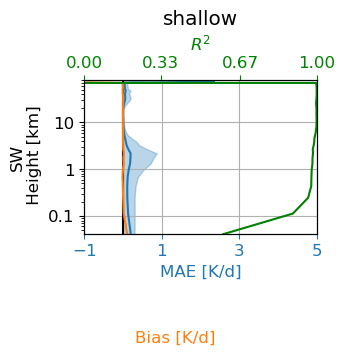

In [26]:
# (Mostly) shallow convection

condition = lambda this_atm: (( this_atm["clt"]>0.1)
                         & ( this_atm["extra_2d_iwp"]<1e-4))
                         # ICON: cloud fraction = 0 if cloud ice+liquid < 1.e-8 kg/kg
                         # vertical integral of cloud ice * rho * dz 
                         # ==> average 3e-4 kg/m^2 and minimum 2e-4 kg/m^2
                                     
t, p, s, h = filter_samples_ml(results_sw, condition,  xtitle="shallow",mode='sw')
fig, ax = plt.subplots(1,1, figsize=(3,2))
subplot_height(ax ,s, h, "mae", xlabel=True, ylabel=True, topx=True, 
                                      scale="log", xlim=(-1, 5), xtitle="shallow", ytitle="SW")

In [5]:
def combined_plot(atm_ref, conditions, rows, labels_columns, labels_rows, mode, ylim=(0,20), fname=""):
    mpl.rcParams['font.size'] = '18'
    width_subplot = 3
    height_subplot = 2
    n_rows= len(rows)
    n_columns = len(conditions)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*width_subplot, n_rows*height_subplot), constrained_layout=True)
    
    for r, row_axes in enumerate(axs):
        #print(labels_rows[r])
        for c, ax in enumerate(row_axes):
            #print(labels_columns[c])
            xlabel = True if r == n_rows - 1 else False
            ylabel = True if c == 0 else False
            topx = True if r == 0 else False
        
            if "ML" in labels_rows[r]:
                try:
                    t, p, s, h = filter_samples_ml(rows[r], conditions[c], xtitle=labels_columns[c], mode=mode[r])
                    subplot_height(ax ,s, h, "mae", xlabel=xlabel, ylabel=ylabel, topx=topx, 
                               scale="linear", xlim=(-1, 5), ylim=ylim, 
                               xtitle=labels_columns[c], ytitle=labels_rows[r] )
                    if "clear" == labels_columns[c]:
                        gray_overlay(ax)
                except Exception as e: print(e)
            else:
                t, p, s, h = filter_samples_pyrte(atm_ref[r], rows[r], conditions[c], xtitle=labels_columns[c], mode=mode[r])
                subplot_height(ax ,s, h, "mae", xlabel=xlabel, ylabel=ylabel, topx=topx, 
                           scale="linear", xlim=(-1, 5), 
                           xtitle=labels_columns[c], ytitle=labels_rows[r] , ylim=ylim)
    plt.savefig(fname+".pdf")
    plt.show()
    plt.close()

SW clear & 0.367 (8.47 \%) & 0.234 (4.91 \%) & 0.91 & 0.443 (10.56 \%) \\
SW cloudy & 0.445 (16.73 \%) & 0.204 (4.22 \%) & 0.83 & 0.789 (41.54 \%) \\
SW partial & 0.470 (12.24 \%) & 0.273 (4.65 \%) & 0.82 & 0.683 (23.55 \%) \\
SW non-precip. clouds & 0.493 (12.11 \%) & 0.292 (4.79 \%) & 0.87 & 0.711 (19.98 \%) \\
SW precip. clouds & 0.778 (32.62 \%) & 0.244 (17.28 \%) & 0.59 & 1.250 (58.35 \%) \\
SW clear & 0.049 (0.49 \%) & -0.000 (-0.00 \%) & 0.99 & 0.074 (0.72 \%) \\
SW cloudy & 0.106 (4.46 \%) & 0.012 (0.98 \%) & 0.98 & 0.214 (11.30 \%) \\
SW partial & 0.082 (2.00 \%) & 0.005 (0.23 \%) & 0.99 & 0.150 (5.00 \%) \\
SW non-precip. clouds & 0.080 (1.57 \%) & 0.006 (0.24 \%) & 0.99 & 0.144 (3.50 \%) \\
SW precip. clouds & 0.188 (9.16 \%) & 0.024 (2.87 \%) & 0.96 & 0.341 (17.71 \%) \\
LW clear & 0.564 (23.56 \%) & -0.349 (-9.85 \%) & 0.83 & 0.677 (30.09 \%) \\
LW cloudy & 0.862 (41.08 \%) & -0.296 (-8.35 \%) & 0.67 & 1.478 (81.55 \%) \\
LW partial & 0.694 (25.83 \%) & -0.328 (-7.74 \%) &

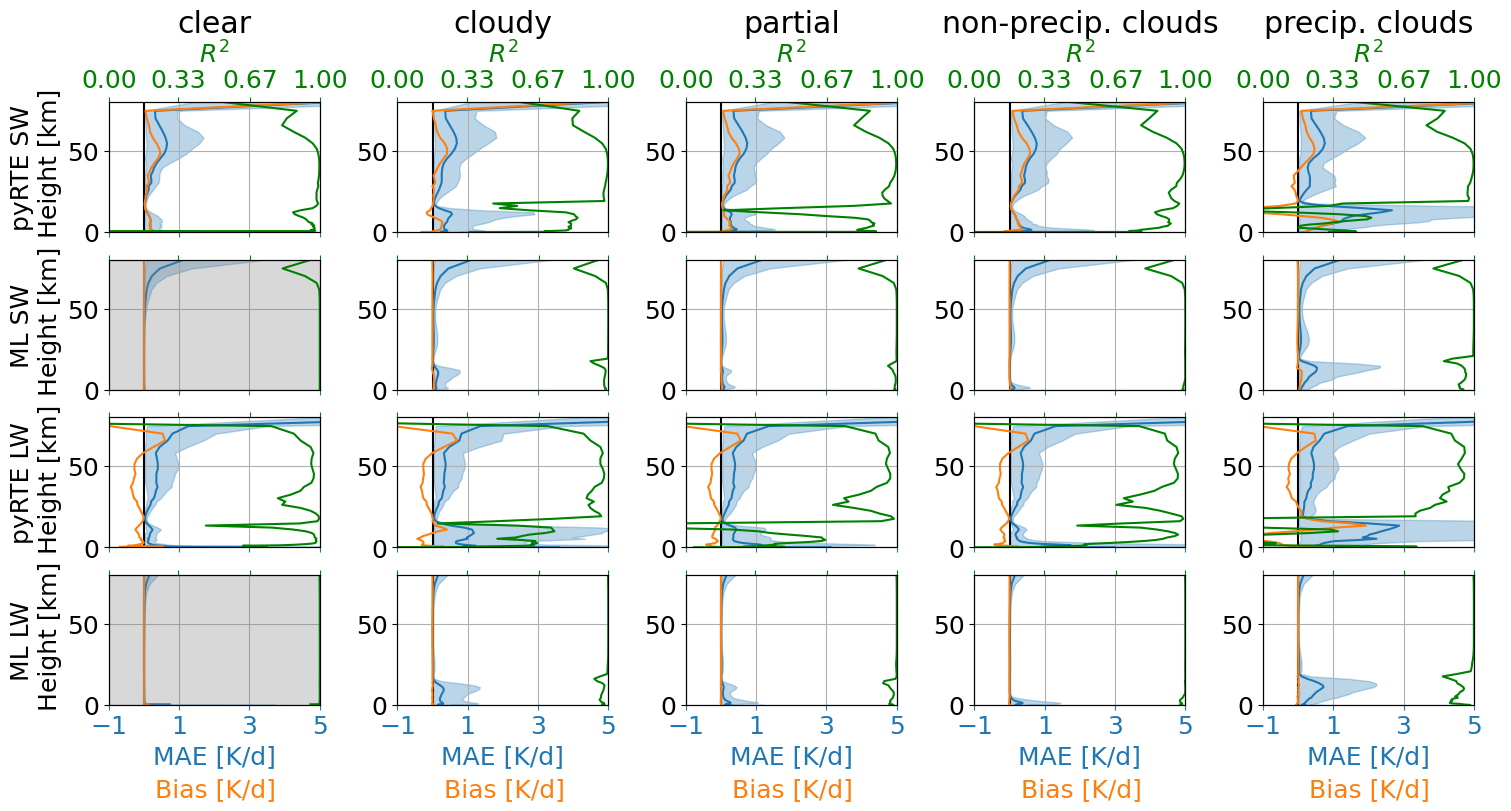

In [8]:
clear = lambda a: a["clt"] == 0
cloudy = lambda a: a["clt"]== 1
partial = lambda a: (a["clt"] > 0.1) & (a["clt"] < 0.9)

shallow = lambda a: (   (a["pr"]<0.01/3600) # precip flux below 0.1 mm/h
                     & ( a["clt"]>0.1)
                     & ( a["extra_2d_iwp"]<1e-4))
# ICON: cloud fraction = 0 if cloud ice+liquid < 1.e-8 kg/kg
# vertical integral of cloud ice * rho * dz 
# ==> average 3e-4 kg/m^2 and minimum 2e-4 kg/m^2
                     
deep =  lambda a:(a["pr"]>3/3600) & ( a["clt"]>0)

conditions = [clear, cloudy, partial,shallow, deep]
labels_columns = ["clear", "cloudy", "partial", "non-precip. clouds", "precip. clouds"]
#rows = [fluxes_pyrte_sw, tend_ta_sw_ml, fluxes_pyrte_lw, tend_ta_lw_ml]
rows = [fluxes_pyrte_sw, results_sw, fluxes_pyrte_lw, results_lw]
atm_ref = [atm_sw, atm_sw, atm_lw, atm_lw]
labels_rows = ["pyRTE SW", "ML SW", "pyRTE LW", "ML LW"]
mode = ["sw", "sw", "lw", "lw"]
#combined_plot(atm_ref, conditions, rows, labels_columns, labels_rows, mode, fname="general")
combined_plot(atm_ref, conditions, rows, labels_columns, labels_rows, mode, ylim=(0,80),fname="general_full")

SW Arctic & 0.215 (9.55 \%) & 0.114 (3.73 \%) & 0.92 & 0.326 (17.99 \%) \\
SW Southern Ocean & 0.417 (13.34 \%) & 0.218 (3.32 \%) & 0.87 & 0.665 (27.68 \%) \\
SW Tropics & 0.535 (13.86 \%) & 0.290 (4.39 \%) & 0.80 & 0.817 (29.42 \%) \\
SW Pacific ITCZ & 0.638 (18.33 \%) & 0.271 (6.27 \%) & 0.76 & 0.964 (33.67 \%) \\
SW stratocumulus & 0.529 (13.66 \%) & 0.289 (4.38 \%) & 0.80 & 0.825 (28.97 \%) \\
SW Arctic & 0.056 (2.17 \%) & 0.006 (0.58 \%) & 0.99 & 0.098 (4.84 \%) \\
SW Southern Ocean & 0.089 (2.98 \%) & 0.005 (0.34 \%) & 0.99 & 0.174 (7.30 \%) \\
SW Tropics & 0.097 (2.61 \%) & 0.009 (0.47 \%) & 0.98 & 0.187 (7.32 \%) \\
SW Pacific ITCZ & 0.142 (4.50 \%) & 0.019 (1.17 \%) & 0.98 & 0.247 (9.73 \%) \\
SW stratocumulus & 0.095 (2.48 \%) & 0.008 (0.41 \%) & 0.99 & 0.179 (6.38 \%) \\
LW Arctic & 0.634 (30.75 \%) & -0.254 (-14.89 \%) & 0.77 & 1.046 (55.94 \%) \\
LW Southern Ocean & 0.787 (30.60 \%) & -0.318 (-8.64 \%) & 0.69 & 1.307 (56.70 \%) \\
LW Tropics & 0.755 (30.96 \%) & -0.326 (-4

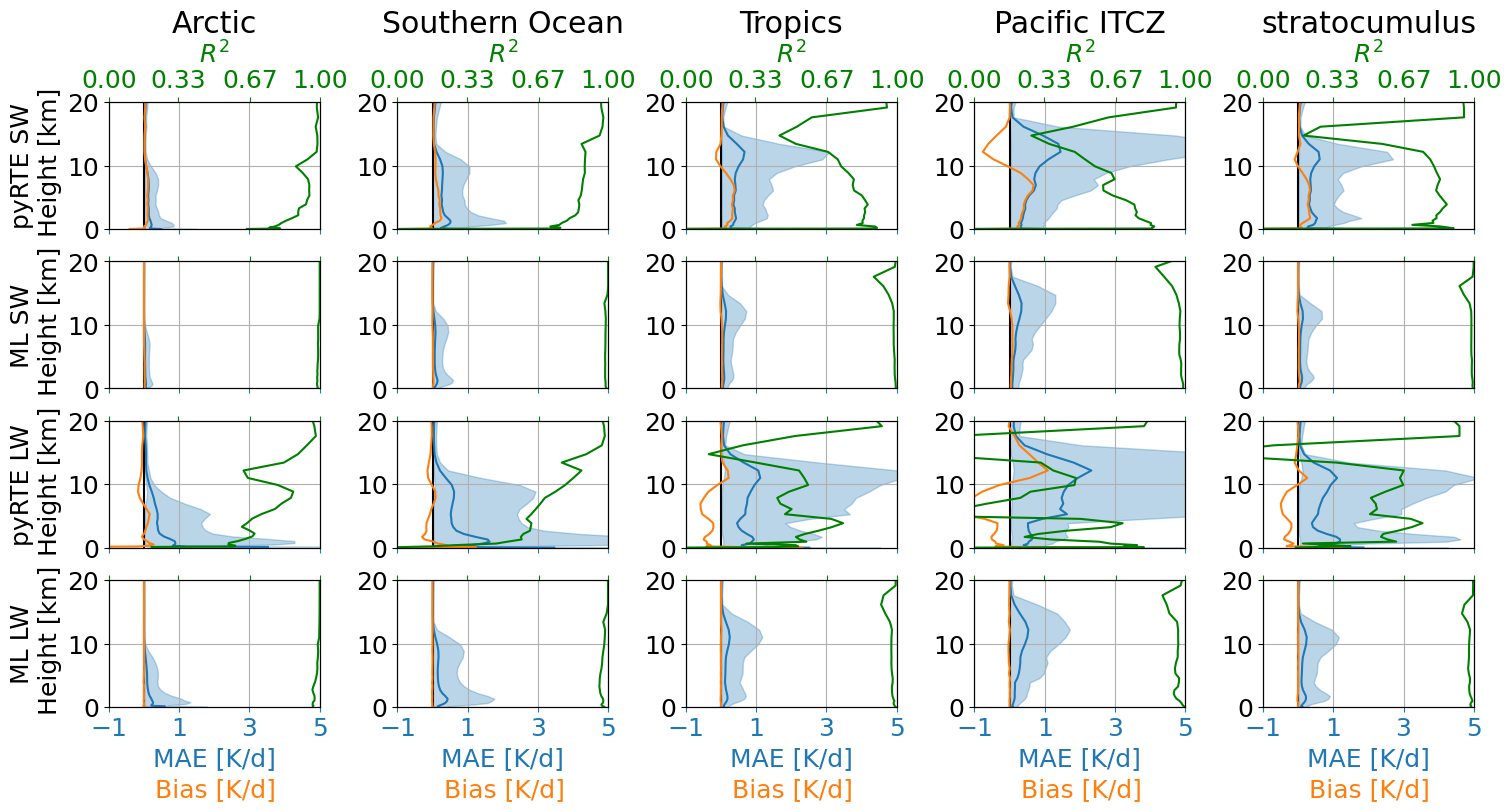

In [7]:

# regions as in Figure 5 in Bock & Lauer 2024 https://doi.org/10.5194/acp-24-1587-2024
region_1 = lambda a: np.isin(a["cell_idx"], vgrid.ncells[vgrid["clat"].values>70/180*np.pi].values)
cell_conditions_2 = (vgrid["clat"].values>-65/180*np.pi) & (vgrid["clat"].values<-30/180*np.pi)
region_2 = lambda a: np.isin(a["cell_idx"], vgrid.ncells[cell_conditions_2].values)
region_3 = lambda a: np.isin(a["cell_idx"], vgrid.ncells[(np.abs(vgrid["clat"].values)<30/180*np.pi) & (vgrid["sftof"].values==1)].values)
cell_conditions_4 = ( ((vgrid["clat"].values>0/180*np.pi) & (vgrid["clat"].values<12/180*np.pi) )
                  & ((vgrid["clon"].values>135/180*np.pi) & (vgrid["clon"].values<(360-85)/180*np.pi) )
                  )
region_4 = lambda a: np.isin(a["cell_idx"], vgrid.ncells[cell_conditions_4].values)
cells_5a = ( ((vgrid["clat"].values>-30/180*np.pi) & (vgrid["clat"].values<-10/180*np.pi) )
           & ((vgrid["clon"].values>(360-95)/180*np.pi) & (vgrid["clon"].values<(360-75)/180*np.pi) )
           )
cells_5b = ( ((vgrid["clat"].values>-30/180*np.pi) & (vgrid["clat"].values<-10/180*np.pi) )
           & ((vgrid["clon"].values>350/180*np.pi) | (vgrid["clon"].values<10/180*np.pi) )
           )
cells_5c = ( ((vgrid["clat"].values>15/180*np.pi) & (vgrid["clat"].values<35/180*np.pi) )
           & ((vgrid["clon"].values>(360-140)/180*np.pi) & (vgrid["clon"].values<(360-120)/180*np.pi) )
           )
region_5 =  lambda a: np.isin(a["cell_idx"], vgrid.ncells[(cells_5a | cells_5b | cells_5c)].values)
conditions = [ region_1, region_2, region_3, region_4, region_5]
labels_columns = ["Arctic", "Southern Ocean", "Tropics", "Pacific ITCZ", "stratocumulus"]
#rows = [fluxes_pyrte_sw, tend_ta_sw_ml, fluxes_pyrte_lw, tend_ta_lw_ml]
rows = [fluxes_pyrte_sw, results_sw, fluxes_pyrte_lw, results_lw]
atm_ref = [atm_sw, atm_sw, atm_lw, atm_lw]
labels_rows = ["pyRTE SW", "ML SW", "pyRTE LW", "ML LW"]
mode = ["sw", "sw", "lw", "lw"]
combined_plot(atm_ref, conditions, rows, labels_columns, labels_rows, mode, fname="regions")

In [ ]:
def cloud_layers(cf):
    """
    cloud fraction of size (levels, cells)
    """
    
    starts = (cf[1:] > 0) & (cf[:-1] == 0)   # boolean mask
    n_layers = starts.sum(axis=0)
    return n_layers
# cloud layers
cl_layers = lambda a: cloud_layers(a["cl"]) == 4
#high_zenith = lambda a: a["cosmu0"].values>0.9
#low_zenith = lambda a: a["cosmu0"].values<0.1
land = lambda a: np.isin(a["cell_idx"], vgrid.ncells[np.abs(vgrid["sftlf"].values)==1].values)
ocean = lambda a: np.isin(a["cell_idx"], vgrid.ncells[np.abs(vgrid["sftof"].values)==1].values)
ice = lambda a: np.isin(a["cell_idx"], vgrid.ncells[np.abs(vgrid["sftgif"].values)==1].values)
mountains = lambda a: np.isin(a["cell_idx"], vgrid.ncells[np.abs(vgrid["orog"].values)>1200].values)

conditions = [cl_layers, land, ocean, ice, mountains]
labels_columns = ["cloud_layers", "land", "ocean", "ice", "mountains"]
#rows = [fluxes_pyrte_sw, tend_ta_sw_ml, fluxes_pyrte_lw, tend_ta_lw_ml]
rows = [fluxes_pyrte_sw, results_sw, fluxes_pyrte_lw, results_lw]
atm_ref = [atm_sw, atm_sw, atm_lw, atm_lw]
labels_rows = ["pyRTE SW", "ML SW", "pyRTE LW", "ML LW"]
mode = ["sw", "sw", "lw", "lw"]
combined_plot(atm_ref, conditions, rows, labels_columns, labels_rows, mode)
